In [2]:
import os
from PIL import Image


image_folder = "men_random_50"   # <-- this is the actual correct path
valid_ext = (".jpg", ".jpeg", ".png", ".webp")
image_paths = []
images = []

for fname in os.listdir(image_folder):
    if fname.lower().endswith(valid_ext):
        fpath = os.path.join(image_folder, fname)
        img = Image.open(fpath).convert("RGB")
        images.append(img)
        image_paths.append(fpath)

print(f"Loaded {len(images)} images.")

Loaded 50 images.


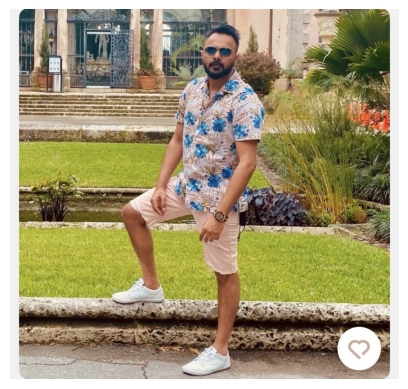

In [3]:
import matplotlib.pyplot as plt

plt.imshow(images[1])
plt.axis("off")
plt.show()

In [4]:
import base64
import requests
import json
from PIL import Image
import io
import numpy as np
import os

from langchain_huggingface import HuggingFaceEndpoint
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Load HF Token
from dotenv import load_dotenv
load_dotenv()
HF_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")

print("HF Token Loaded:", HF_TOKEN is not None)

HF Token Loaded: True


In [5]:
!pip install transformers accelerate timm open_clip_torch


  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
Using cached huggingface_hub-0.36.0-py3-none-any.whl (566 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 1.1.6
    Uninstalling huggingface_hub-1.1.6:
      Successfully uninstalled huggingface_hub-1.1.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.10.0 which is incompatible.
hf-inference 0.1.0 requires numpy<2.0.0,>=1.15.0, but you have numpy 2.3.5 which is incompatible.
hf-inference 0.1.0 requires pillow~=11.3, but you have pillow 12.0.0 which is incompatible.
hf-inference 0.1.0 requires torch~=2.8.0, but you have torch 2.9.1 which is incompatible.
hf-inference 0.1.0 requires torchvision~=0.23.0, but you have torchvision 0.24.1 which is incompatible.


In [6]:
import torch
from transformers import AutoProcessor, AutoModelForCausalLM, AutoModelForVision2Seq

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

#############################################
# 1) BODY MODEL — Qwen2-VL (attributes/appearance)
#############################################
from transformers import AutoProcessor as QwenProcessor
from transformers import AutoModelForCausalLM as QwenVL

BODY_MODEL_NAME = "Qwen/Qwen2-VL-2B-Instruct"
body_processor = QwenProcessor.from_pretrained(BODY_MODEL_NAME)
body_model = QwenVL.from_pretrained(
    BODY_MODEL_NAME,
    torch_dtype=torch.float16 if DEVICE=="cuda" else torch.float32
).to(DEVICE)


#############################################
# 2) BACKGROUND MODEL — Florence 2 (scene tagging)
#############################################
BG_MODEL_NAME = "microsoft/Florence-2-large"
bg_processor = AutoProcessor.from_pretrained(BG_MODEL_NAME)
bg_model = AutoModelForVision2Seq.from_pretrained(
    BG_MODEL_NAME,
    torch_dtype=torch.float16 if DEVICE=="cuda" else torch.float32
).to(DEVICE)


#############################################
# 3) ACTIVITY MODEL — BLIP Captioning (actions/objects)
#############################################
ACT_MODEL_NAME = "Salesforce/blip-image-captioning-large"
act_processor = AutoProcessor.from_pretrained(ACT_MODEL_NAME)
act_model = AutoModelForVision2Seq.from_pretrained(
    ACT_MODEL_NAME,
    torch_dtype=torch.float16 if DEVICE=="cuda" else torch.float32
).to(DEVICE)

print("All three models loaded.")


c:\Users\aryan\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\loss\loss_for_object_detection.py:28: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  from scipy.optimize import linear_sum_assignment


Using: cpu


preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

c:\Users\aryan\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\aryan\.cache\huggingface\hub\models--Qwen--Qwen2-VL-2B-Instruct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


ValueError: Unrecognized configuration class <class 'transformers.models.qwen2_vl.configuration_qwen2_vl.Qwen2VLConfig'> for this kind of AutoModel: AutoModelForCausalLM.
Model type should be one of ApertusConfig, ArceeConfig, AriaTextConfig, BambaConfig, BartConfig, BertConfig, BertGenerationConfig, BigBirdConfig, BigBirdPegasusConfig, BioGptConfig, BitNetConfig, BlenderbotConfig, BlenderbotSmallConfig, BloomConfig, BltConfig, CamembertConfig, LlamaConfig, CodeGenConfig, CohereConfig, Cohere2Config, CpmAntConfig, CTRLConfig, Data2VecTextConfig, DbrxConfig, DeepseekV2Config, DeepseekV3Config, DiffLlamaConfig, DogeConfig, Dots1Config, ElectraConfig, Emu3Config, ErnieConfig, Ernie4_5Config, Ernie4_5_MoeConfig, Exaone4Config, FalconConfig, FalconH1Config, FalconMambaConfig, FlexOlmoConfig, FuyuConfig, GemmaConfig, Gemma2Config, Gemma3Config, Gemma3TextConfig, Gemma3nConfig, Gemma3nTextConfig, GitConfig, GlmConfig, Glm4Config, Glm4MoeConfig, GotOcr2Config, GPT2Config, GPT2Config, GPTBigCodeConfig, GPTNeoConfig, GPTNeoXConfig, GPTNeoXJapaneseConfig, GptOssConfig, GPTJConfig, GraniteConfig, GraniteMoeConfig, GraniteMoeHybridConfig, GraniteMoeSharedConfig, HeliumConfig, HunYuanDenseV1Config, HunYuanMoEV1Config, JambaConfig, JetMoeConfig, Lfm2Config, LlamaConfig, Llama4Config, Llama4TextConfig, LongcatFlashConfig, MambaConfig, Mamba2Config, MarianConfig, MBartConfig, MegaConfig, MegatronBertConfig, MiniMaxConfig, MinistralConfig, MistralConfig, MixtralConfig, MllamaConfig, ModernBertDecoderConfig, MoshiConfig, MptConfig, MusicgenConfig, MusicgenMelodyConfig, MvpConfig, NemotronConfig, OlmoConfig, Olmo2Config, Olmo3Config, OlmoeConfig, OpenLlamaConfig, OpenAIGPTConfig, OPTConfig, PegasusConfig, PersimmonConfig, PhiConfig, Phi3Config, Phi4MultimodalConfig, PhimoeConfig, PLBartConfig, ProphetNetConfig, QDQBertConfig, Qwen2Config, Qwen2MoeConfig, Qwen3Config, Qwen3MoeConfig, Qwen3NextConfig, RecurrentGemmaConfig, ReformerConfig, RemBertConfig, RobertaConfig, RobertaPreLayerNormConfig, RoCBertConfig, RoFormerConfig, RwkvConfig, SeedOssConfig, SmolLM3Config, Speech2Text2Config, StableLmConfig, Starcoder2Config, TransfoXLConfig, TrOCRConfig, VaultGemmaConfig, WhisperConfig, XGLMConfig, XLMConfig, XLMProphetNetConfig, XLMRobertaConfig, XLMRobertaXLConfig, XLNetConfig, xLSTMConfig, XmodConfig, ZambaConfig, Zamba2Config.

In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

############################################################
# 1) BODY MODEL — Qwen2-VL (attributes / appearance)
############################################################
BODY_MODEL_NAME = "Qwen/Qwen2-VL-2B-Instruct"

body_processor = AutoProcessor.from_pretrained(BODY_MODEL_NAME)
body_model = AutoModelForVision2Seq.from_pretrained(
    BODY_MODEL_NAME,
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32
).to(DEVICE)


############################################################
# 2) BACKGROUND MODEL — Florence 2 (scene tagging)
############################################################
BG_MODEL_NAME = "microsoft/Florence-2-large"

bg_processor = AutoProcessor.from_pretrained(BG_MODEL_NAME)
bg_model = AutoModelForVision2Seq.from_pretrained(
    BG_MODEL_NAME,
    trust_remote_code=True,    # required for Florence
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32
).to(DEVICE)


############################################################
# 3) ACTIVITY MODEL — BLIP Captioning (actions/objects)
############################################################
ACT_MODEL_NAME = "Salesforce/blip-image-captioning-large"

act_processor = AutoProcessor.from_pretrained(ACT_MODEL_NAME)
act_model = AutoModelForVision2Seq.from_pretrained(
    ACT_MODEL_NAME,
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32
).to(DEVICE)

print("All three models loaded successfully.")

Using: cpu


c:\Users\aryan\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\auto\modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]